In [ ]:
import networkx as nx
import itertools
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [5]:
df_filtrado=pd.read_csv("Datos alumnos/Trasformados/df_para_grafo.csv")

# Grafo


### Regla 1 (Nivel)

In [6]:

G = nx.Graph()
for idx, row in df_filtrado.iterrows():
    G.add_node(idx, **row.to_dict())

valid_connections = [
    (1, 2),
    (1, 3),
    (2, 2),
    (2, 3),
    (3, 3)
]

print("Generando conexiones del grafo...")

count = 0

for u, v in itertools.combinations(G.nodes, 2):

    nivel_u = G.nodes[u]["nivel"]
    nivel_v = G.nodes[v]["nivel"]

    pair = tuple(sorted((nivel_u, nivel_v)))

    if pair in valid_connections:
        G.add_edge(u, v, rule="nivel")
        count += 1

print(f"¡Hecho! Se han creado {count} conexiones siguiendo el esquema de niveles.")
print("Nodos (Prendas):", G.number_of_nodes())
print("Aristas (Conexiones):", G.number_of_edges())

edges_1_1 = 0
for u, v in G.edges:
    if G.nodes[u]['nivel'] == 1 and G.nodes[v]['nivel'] == 1:
        edges_1_1 += 1



Generando conexiones del grafo...
¡Hecho! Se han creado 13894206 conexiones siguiendo el esquema de niveles.
Nodos (Prendas): 5614
Aristas (Conexiones): 13894206
Verificación: Conexiones 1-1 encontradas (debería ser 0): 0


### Regla 2 (Season)

In [7]:
# Recorremos todas las aristas
for u, v in list(G.edges):
    if G.nodes[u]["season_code"] != G.nodes[v]["season_code"]:
        # quitamos arista si no coinciden las season
        G.remove_edge(u, v)


In [8]:
print("Nodos:", G.number_of_nodes())
print("Aristas:", G.number_of_edges())
print("Componentes conexas:", nx.number_connected_components(G))

Nodos: 5614
Aristas: 4637758
Componentes conexas: 3


### Regla 3 (Weather)

In [9]:
def normalizar_weather(weather):
    if weather in ["warm", "warm_season"]:
        return "W"
    elif weather in ["cold", "cold_season"]:
        return "C"
    else:
        return None  # si hay algún valor extraño

for n in G.nodes:
    G.nodes[n]["weather_norm"] = normalizar_weather(G.nodes[n]["weather"])

for u, v in list(G.edges):
    if G.nodes[u]["weather_norm"] != G.nodes[v]["weather_norm"]:
        G.remove_edge(u, v)


In [10]:
print("Nodos:", G.number_of_nodes())
print("Aristas:", G.number_of_edges())
print("Componentes conexas:", nx.number_connected_components(G))

Nodos: 5614
Aristas: 2739435
Componentes conexas: 6


### Regla 4 (Adventourous)

In [11]:
risk_mapping = {
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5
}

def get_risk_number(value):
    val_str = str(value).lower().strip()
    return risk_mapping.get(val_str, 0)

for n in G.nodes:
    raw_val = G.nodes[n].get("adventurous", "one")
    G.nodes[n]["risk_score"] = get_risk_number(raw_val)

edges_removed = 0
for u, v in list(G.edges):
    risk_u = G.nodes[u]["risk_score"]
    risk_v = G.nodes[v]["risk_score"]

    if risk_u >= 4 and risk_v >= 4:
        G.remove_edge(u, v)
        edges_removed += 1

print(f"Regla Adventurous aplicada: Se eliminaron {edges_removed} conexiones entre prendas de alto riesgo.")


Regla Adventurous aplicada: Se eliminaron 1425 conexiones entre prendas de alto riesgo.


In [12]:
print("Nodos:", G.number_of_nodes())
print("Aristas:", G.number_of_edges())
print("Componentes conexas:", nx.number_connected_components(G))

Nodos: 5614
Aristas: 2738010
Componentes conexas: 6


In [13]:
style_map_inv = {
    "boho": "B",
    "casual": "CA",
    "classic": "CL",
    "street": "S",
    "night": "N",
    "minimal": "M"
}

for n in G.nodes:
    raw_style = str(G.nodes[n].get("style", "")).lower().strip()
    G.nodes[n]["style_code"] = style_map_inv.get(raw_style, None)

allowed_style_pairs_list = [
    ("B", "B"), ("B", "CA"), ("B", "M"),
    ("CA", "CA"), ("CA", "B"), ("CA", "M"), ("CA", "S"), ("CA", "CL"),
    ("CL", "CL"), ("CL", "M"), ("CL", "CA"), ("CL", "N"),
    ("M", "M"), ("M", "CA"), ("M", "CL"), ("M", "S"),
    ("S", "S"), ("S", "CA"), ("S", "M"),
    ("N", "N"), ("N", "CL"), ("N", "M")
]

allowed_styles = set()
for s1, s2 in allowed_style_pairs_list:
    allowed_styles.add(tuple(sorted((s1, s2))))

removed_count = 0
for u, v in list(G.edges):
    s1 = G.nodes[u]["style_code"]
    s2 = G.nodes[v]["style_code"]

    if s1 is None or s2 is None:
        G.remove_edge(u, v)
        removed_count += 1
        continue

    pair = tuple(sorted((s1, s2)))

    if pair not in allowed_styles:
        G.remove_edge(u, v)
        removed_count += 1

print(f"Regla Estilos aplicada: Se han eliminado {removed_count} conexiones por estilo incompatible.")


Regla Estilos aplicada: Se han eliminado 1036195 conexiones por estilo incompatible.


In [14]:
print("Nodos:", G.number_of_nodes())
print("Aristas:", G.number_of_edges())
print("Componentes conexas:", nx.number_connected_components(G))

Nodos: 5614
Aristas: 1701815
Componentes conexas: 6


### Regla 6 (colores)

In [ ]:

yellow_compatible = {
    "white": 5,
    "black": 4,
    "khaki": 3,
    "blue_dark": 4,
    "camel": 2,
    "grey": 3,
    "red": 2,
    "brown_light": 3
}

color_dict = {}
try:
    if 'colores_df' not in locals():
        colores_df = pd.read_csv('Datos alumnos/Trasformados/df_sino_actualizado.csv')

    for _, row in colores_df.iterrows():
        c1 = row["Color A"]
        c2 = row["Color B"]
        match = row["Match"]
        score = row["Score"]

        final_score = score if match == 'YES' else 0

        color_dict[(c1, c2)] = final_score
        color_dict[(c2, c1)] = final_score

except NameError:
    print("Error: No se encuentra el dataframe de colores.")

edges_removed = 0
edges_rescued = 0

for u, v in list(G.edges):
    color_u = G.nodes[u].get("color_name", "")
    color_v = G.nodes[v].get("color_name", "")

    score = color_dict.get((color_u, color_v), 0)

    if score > 0:
        G.edges[u, v]["weight_color"] = score

    else:
        rescued = False

        if color_u == "yellow" and color_v in yellow_compatible:
            G.edges[u, v]["weight_color"] = yellow_compatible[color_v]
            rescued = True

        elif color_v == "yellow" and color_u in yellow_compatible:
            G.edges[u, v]["weight_color"] = yellow_compatible[color_u]
            rescued = True

        if rescued:
            edges_rescued += 1
        else:
            G.remove_edge(u, v)
            edges_removed += 1

print(f" Filtro aplicado.")
print(f"   - Conexiones eliminadas por color: {edges_removed}")
print(f"   - Conexiones 'Yellow' rescatadas manualmente: {edges_rescued}")
print(f"   - Aristas restantes en el grafo: {G.number_of_edges()}")

isolated = list(nx.isolates(G))
print(f"   - Nodos aislados (sin pareja): {len(isolated)}")


Aplicando filtro de colores con suavizado para Yellow...
 Filtro aplicado.
   - Conexiones eliminadas por color: 938418
   - Conexiones 'Yellow' rescatadas manualmente: 30429
   - Aristas restantes en el grafo: 763397
   - Nodos aislados (sin pareja): 0


In [16]:
print("Nodos:", G.number_of_nodes())
print("Aristas:", G.number_of_edges())
print("Componentes conexas:", nx.number_connected_components(G))

Nodos: 5614
Aristas: 763397
Componentes conexas: 6


### Regla 7 (Corte prenda)

In [17]:
cut_mapping = {
    "contour_darts": "A",
    "central_cut": "A",
    "yoke_cut": "B",
    "back_yoke_cut": "B",
    "front_yoke_cut": "B",
    "biased_cut": "C",
    "lateral": "C",
    "waist_cut": "D",
    "hip_cut": "D",
    "empire_waist": "D",
    "geometric_cut": "E",
    "peplum": "E",
    "asymmetric": "E",
    "other": "E"
}

for n in G.nodes:
    raw_cut = str(G.nodes[n].get("cut", "")).strip()
    group = cut_mapping.get(raw_cut, "A")
    G.nodes[n]["cut_group"] = group

def valid_cut_combination(n1, n2, n3):
    g1 = G.nodes[n1]["cut_group"]
    g2 = G.nodes[n2]["cut_group"]
    g3 = G.nodes[n3]["cut_group"]

    look_groups = [g1, g2, g3]

    if look_groups.count("E") > 1:
        return False

    if look_groups.count("B") > 1:
        return False

    if look_groups.count("D") > 1:
        return False

    if "D" in look_groups and "E" in look_groups:
        return False

    return True


In [18]:
print("Nodos:", G.number_of_nodes())
print("Aristas:", G.number_of_edges())
print("Componentes conexas:", nx.number_connected_components(G))

Nodos: 5614
Aristas: 763397
Componentes conexas: 6


### Regla 8 (Corte prenda)

In [21]:
PRINT_GROUP = {
    "smooth": "A",
    "two_tone": "A",
    "gradient": "A",
    "checked": "B",
    "tartan": "B",
    "prince_of_wales": "B",
    "pied_de_poule": "B",
    "herringbone": "B",
    "vichy": "B",
    "horizontal_stripes": "C",
    "vertical_stripes": "C",
    "diagonal_stripe": "C",
    "geometric": "C",
    "rhombus_fabric": "C",
    "floral": "D",
    "miniprint": "D",
    "polka_dot": "D",
    "retro": "D",
    "ethnic": "D",
    "liberty": "D",
    "bodoque": "D",
    "animal_print": "E",
    "tropical": "E",
    "camouflage": "E",
    "army": "E",
    "tie_dye": "E",
    "printed": "E",
    "other": "E",
}

def get_print_group(p):
    if pd.isna(p):
        return "A"
    return PRINT_GROUP.get(p, "A")

for n in G.nodes:
    G.nodes[n]["print_group"] = get_print_group(G.nodes[n].get("print"))

print("Distribución de print_group:")
print(Counter(nx.get_node_attributes(G, "print_group").values()))

PRINT_COMPATIBILITY = {
    "A": {"A", "B", "C", "D", "E"},
    "B": {"A", "B", "C"},
    "C": {"A", "B"},
    "D": {"A", "B"},
    "E": {"A"},
}

def estampado_edge_allowed(u, v, G):
    p1 = G.nodes[u]["print_group"]
    p2 = G.nodes[v]["print_group"]
    return (p2 in PRINT_COMPATIBILITY[p1]) and (p1 in PRINT_COMPATIBILITY[p2])

edges_before = G.number_of_edges()

edges_to_remove = [
    (u, v)
    for u, v in G.edges()
    if not estampado_edge_allowed(u, v, G)
]

print("Aristas eliminadas por estampado:", len(edges_to_remove))

G.remove_edges_from(edges_to_remove)

print("Aristas antes:", edges_before)
print("Aristas después:", G.number_of_edges())


Distribución de print_group:
Counter({'A': 3998, 'D': 694, 'C': 533, 'E': 259, 'B': 130})
Aristas eliminadas por estampado: 0
Aristas antes: 696943
Aristas después: 696943


### REGLA 9

In [23]:

APPLICATION_GROUP = {
    "freetime": "CASUAL",
    "work": "WORK",
    "working_girl": "WORK",
    "night": "NIGHT",
    "special_occasion": "SPECIAL"
}

APPLICATION_COMPATIBILITY = {
    "CASUAL": {"CASUAL", "WORK"},
    "WORK": {"WORK", "CASUAL"},
    "NIGHT": {"NIGHT", "SPECIAL"},
    "SPECIAL": {"SPECIAL", "NIGHT"}
}

def application_edge_allowed(u, v, G):
    a1 = G.nodes[u].get("application")
    a2 = G.nodes[v].get("application")

    if pd.isna(a1) or pd.isna(a2) or str(a1) == "\\N" or str(a2) == "\\N":
        return True

    g1 = APPLICATION_GROUP.get(a1)
    g2 = APPLICATION_GROUP.get(a2)

    if g1 is None or g2 is None:
        return True

    if g2 in APPLICATION_COMPATIBILITY[g1] and g1 in APPLICATION_COMPATIBILITY[g2]:
        return True

    return False

edges_before = G.number_of_edges()
edges_to_remove = []

for u, v in list(G.edges):
    if not application_edge_allowed(u, v, G):
        edges_to_remove.append((u, v))

G.remove_edges_from(edges_to_remove)

print(f"   - Conexiones eliminadas por incompatibilidad de ocasión: {len(edges_to_remove)}")
print(f"   - Aristas restantes: {G.number_of_edges()}")


   - Conexiones eliminadas por incompatibilidad de ocasión: 0
   - Aristas restantes: 668509


# Visualizacion

Número total de nodos (Season 7): 2000
Número total de aristas (Season 7): 259708
Calculando distribución...


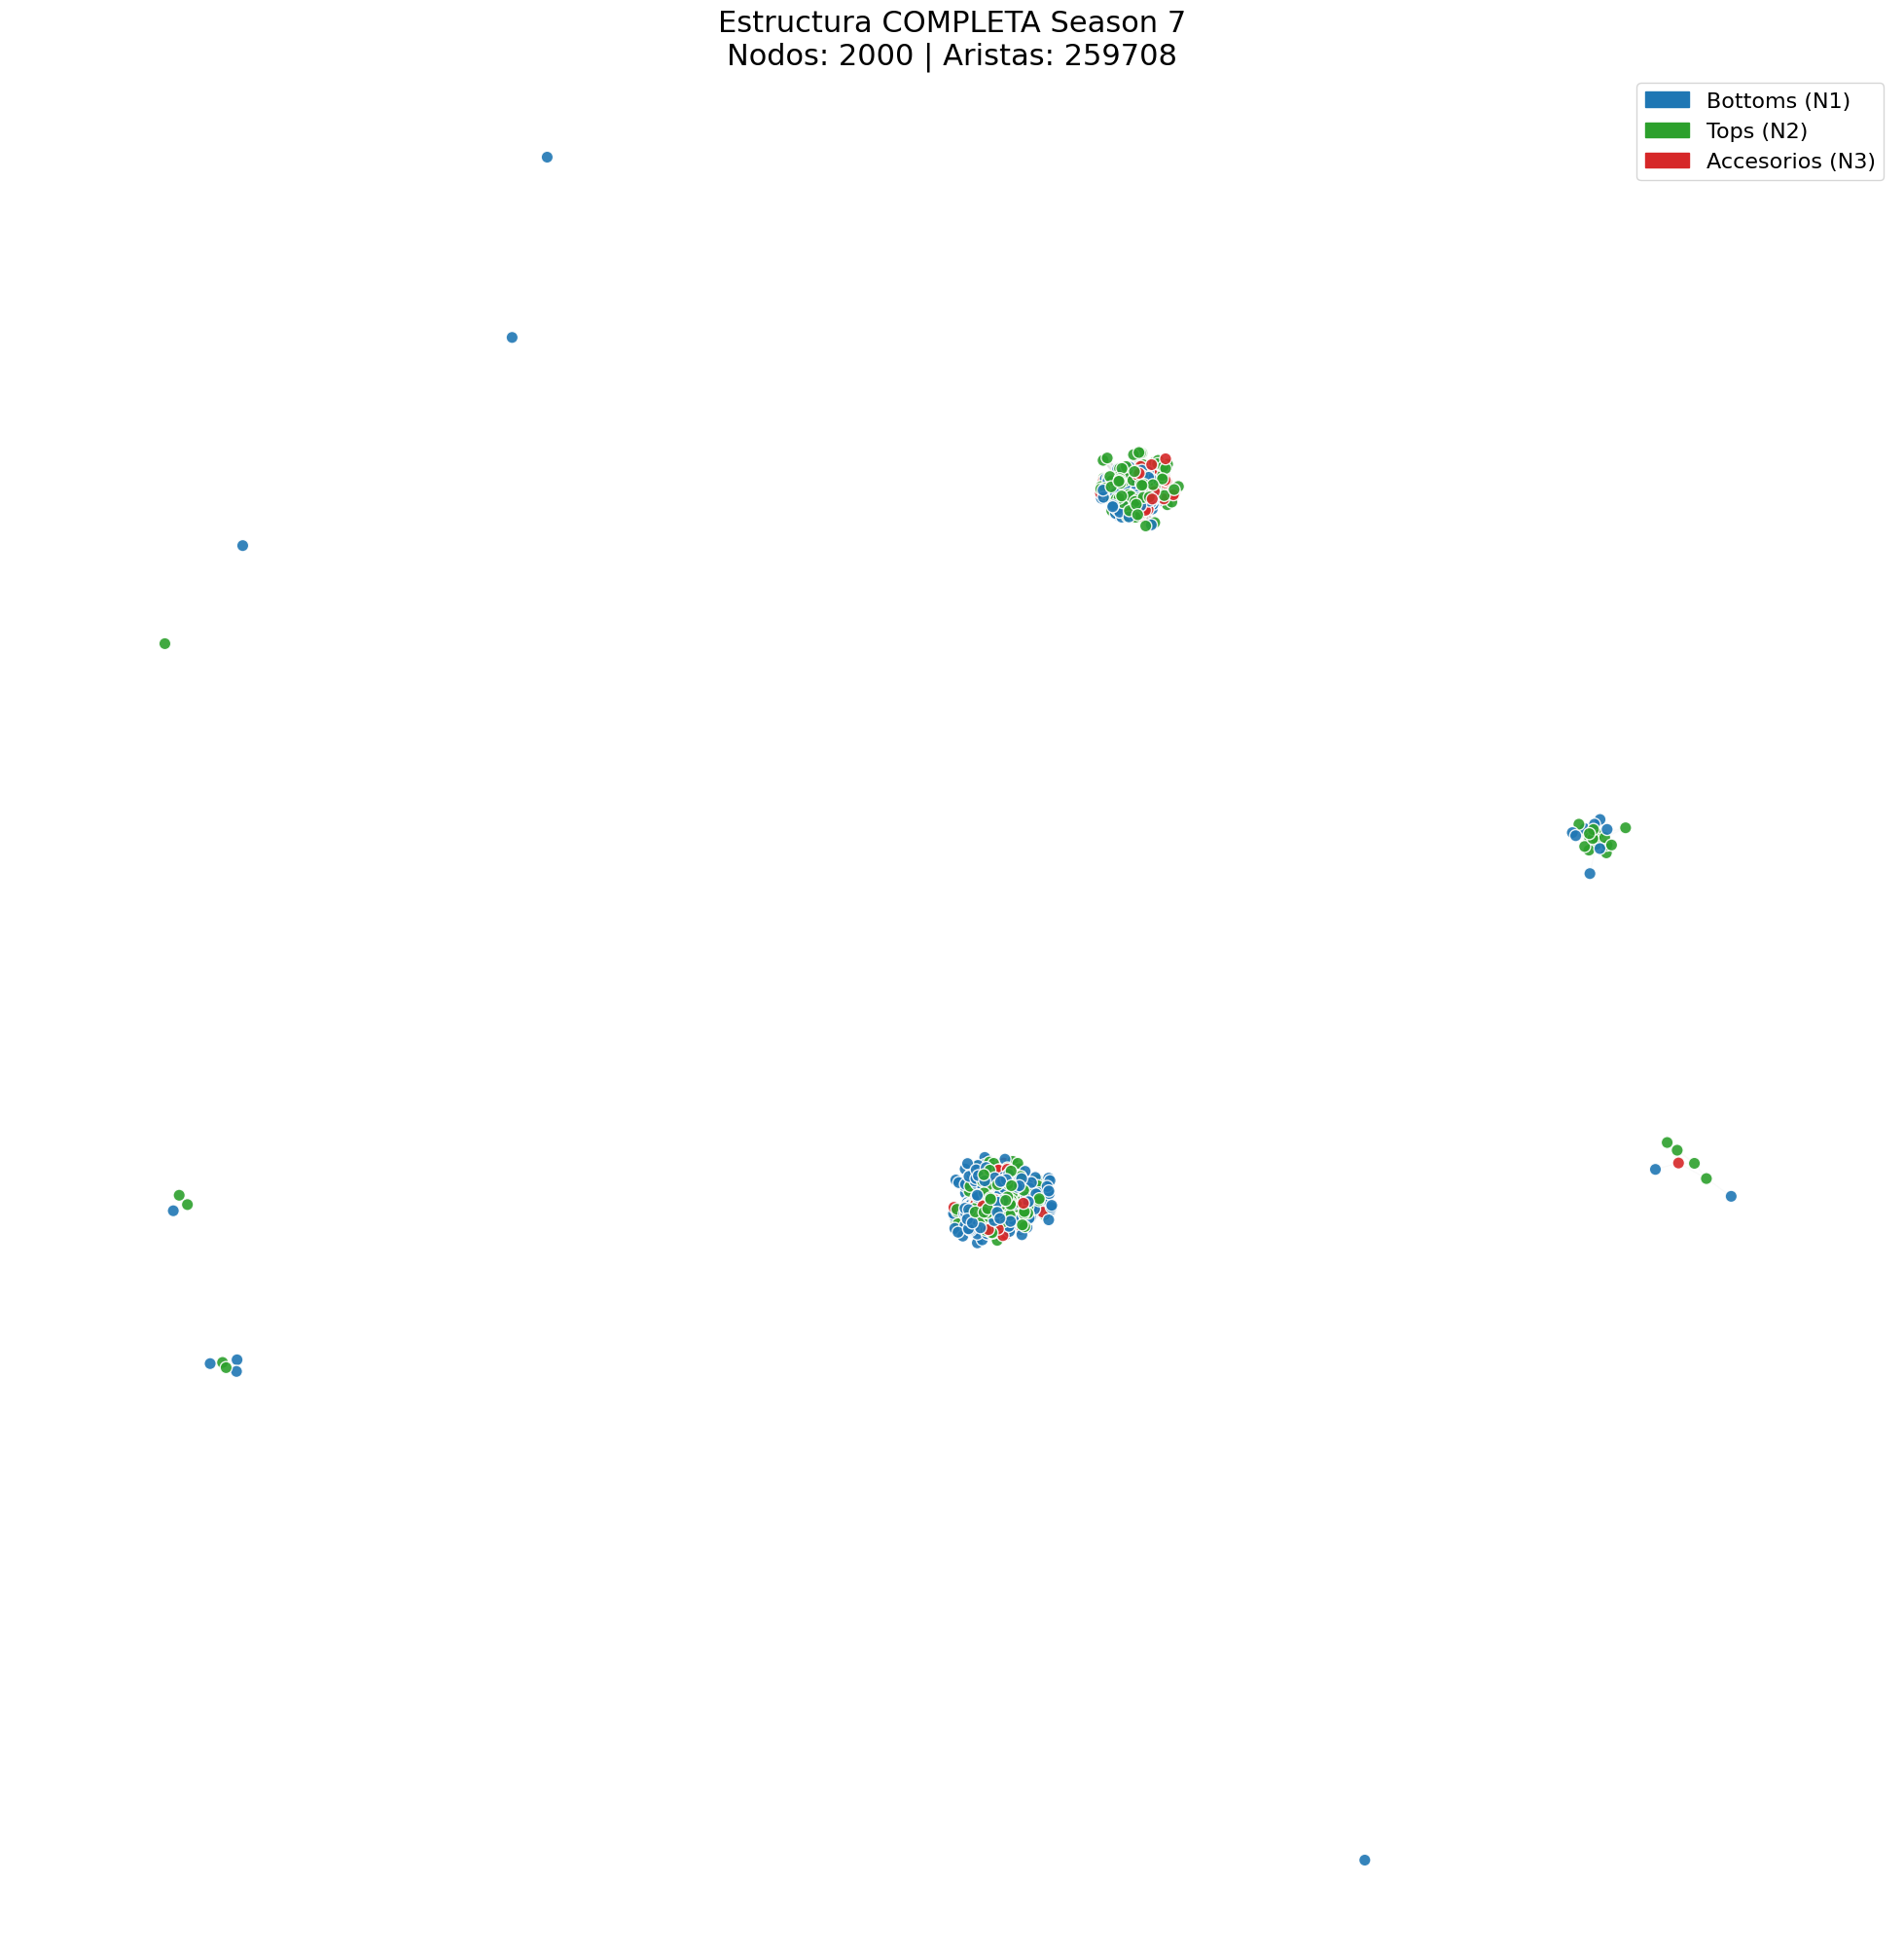

In [28]:


nodes_s7 = [n for n, d in G.nodes(data=True) if d.get("season_code") == 7]
G_viz = G.subgraph(nodes_s7).copy()

num_nodes = G_viz.number_of_nodes()
num_edges = G_viz.number_of_edges()

print(f"Número total de nodos (Season 7): {num_nodes}")
print(f"Número total de aristas (Season 7): {num_edges}")

FIXED_SIZE = 80

nivel_colors = {1: '#1f77b4', 2: '#2ca02c', 3: '#d62728'}
color_map = [
    nivel_colors.get(G_viz.nodes[n].get('nivel', 1), 'grey')
    for n in G_viz.nodes
]

print("Calculando distribución...")
pos = nx.spring_layout(
    G_viz,
    k=0.50,
    iterations=150,
    seed=42
)

plt.figure(figsize=(25, 25))

nx.draw_networkx_edges(
    G_viz, pos,
    alpha=0.05,
    edge_color="#999999"
)

nx.draw_networkx_nodes(
    G_viz, pos,
    node_size=FIXED_SIZE,
    node_color=color_map,
    alpha=0.9,
    edgecolors='white',
    linewidths=1.0
)

patches = [
    mpatches.Patch(color='#1f77b4', label='Bottoms (N1)'),
    mpatches.Patch(color='#2ca02c', label='Tops (N2)'),
    mpatches.Patch(color='#d62728', label='Accesorios (N3)')
]
plt.legend(handles=patches, loc='upper right', fontsize=16)

plt.title(
    f"Estructura COMPLETA Season 7\n"
    f"Nodos: {num_nodes} | Aristas: {num_edges}",
    fontsize=22
)

plt.axis("off")
plt.show()


### vemos aislados

In [29]:
isolated_nodes = list(nx.isolates(G))

isolated_season7 = [
    n for n in isolated_nodes
    if G.nodes[n].get("season_code") == 7
]

print(f"Nodos aislados en season 7: {len(isolated_season7)}")
print(isolated_season7)

G.remove_nodes_from(isolated_season7)

print(f"Nodos aislados de season 7 eliminados del grafo.")


Nodos aislados en season 7: 5
[706, 1104, 2745, 2746, 2747]
Nodos aislados de season 7 eliminados del grafo.


In [32]:

nodes_df = pd.DataFrame.from_dict(
    dict(G_viz.nodes(data=True)),
    orient="index"
).reset_index().rename(columns={"index": "node_id"})

nodes_df.to_csv("Datos alumnos/Trasformados/season7_nodes.csv", index=False)


In [33]:
# Aristas con atributos
edges_df = nx.to_pandas_edgelist(G_viz)

edges_df.to_csv("Datos alumnos/Trasformados/season7_edges.csv", index=False)
